In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Concatenate, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional,Input, Embedding, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re
import ast
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [97]:
#INLADEN DATAFRAME NA PREPROCCESING
dataset=pd.DataFrame()
dataset = pd.read_pickle('verzekeringdataset_Ewoud.pkl')

In [98]:
#Top 6
top_amount = 6
list_top_label_sub = list(dataset["labels.sub_case_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_sub)
dataset = dataset[dataset["labels.sub_case_type"].isin(list_top_label_sub)]
top_amount = 6
list_top_label_damage = list(dataset["labels.damage_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_damage)
dataset = dataset[dataset["labels.damage_type"].isin(list_top_label_damage)]
    
    
  
  



['Fire', 'Operations', 'Familial', '_PrivateClaim', 'Other', 'Auto']
['WaterDamage', 'Other_DamageType', 'Collision', 'Storm', 'Fire_Smoke_Explosion', 'GlassBreakage']


In [99]:
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index().drop('level_7', 1)
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [100]:
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type','language'], axis=1)

In [101]:
y

,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
0,Liability,Operations,Other_DamageType,Bilateral
1,Property,Fire,WaterDamage,Unilateral
2,Property,Fire,WaterDamage,Unilateral
3,Liability,Familial,Collision,Bilateral
4,Liability,Familial,Collision,Bilateral
...,...,...,...,...
9156,Liability,Operations,Collision,Bilateral
9157,Liability,Operations,Collision,Bilateral
9158,Liability,Operations,Collision,Bilateral
9159,Liability,Operations,Collision,Bilateral


In [102]:
#Categorisch maken & top 6 
y['labels.assignment_type'].replace({'Bilateral':0,'Unilateral':1},inplace=True)
y['labels.case_type'].replace({'Liability':0,'Property':1,'Automotive':2},inplace=True)
y['labels.damage_type'].replace({"Storm":0,
        "WaterDamage":1,
        "Other_DamageType":2,
        "GlassBreakage":3,
        "Collision":4,
        "Fire_Smoke_Explosion":5},inplace=True)
y['labels.sub_case_type'].replace({'Fire':0, 'Operations':1, 'Familial':2, '_PrivateClaim':3, 'Other':4, 'Auto':5},inplace=True)

c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [103]:
pd.set_option('display.max_colwidth', 100)
X.head()

,mail_content,attachments_filename,attachments_content
0,br mardi septembre concerne sinistre sans contactons qualit trouverez annexe document relatif s...,VIVIUM GL C301909620 C36 Inspection - DM 2020-09-08 via agt oa bijkomende info foto's,cas dommage materiel si rue royale expert num ro dossier compagnie gestionnaire date sinistre co...
1,bijlage wij document betrekking opdracht toevertrouwd verdediging onze belangen present electro...,MISSION_ASSIGNEMENT mail makelaar - aangifte waterschade foto dakgoot foto dak foto buis buiten ...,nv koning bic btw verzekeringsmaatschappij toegelaten nbb bank codenummer alle beoefenen experts...
2,bijlage wij document betrekking opdracht toevertrouwd verdediging onze belangen present electro...,MISSION_ASSIGNEMENT mail makelaar - aangifte waterschade foto dakgoot foto dak foto buis buiten ...,fotos zien verduidelijking kapot goot goot kunt vinden foto afvoerbuis kunt zien doordat achter ...
3,sans mevrouw contacteren verzekeraar bijlage vindt bericht aanleiding waarbij betrokken wij vra...,Copie police 43 Recours pour la franchise contractuelle - rappel #1 43 Recours pour la franchise...,sent tue mar subject sent subject voir document bijgevoegd document auto conditions particuliere...
4,sans mevrouw contacteren verzekeraar bijlage vindt bericht aanleiding waarbij betrokken wij vra...,Copie police 43 Recours pour la franchise contractuelle - rappel #1 43 Recours pour la franchise...,salutations rapport mission sinistre destinataire local service date informex mandante expert co...


<AxesSubplot:xlabel='labels.damage_type', ylabel='count'>

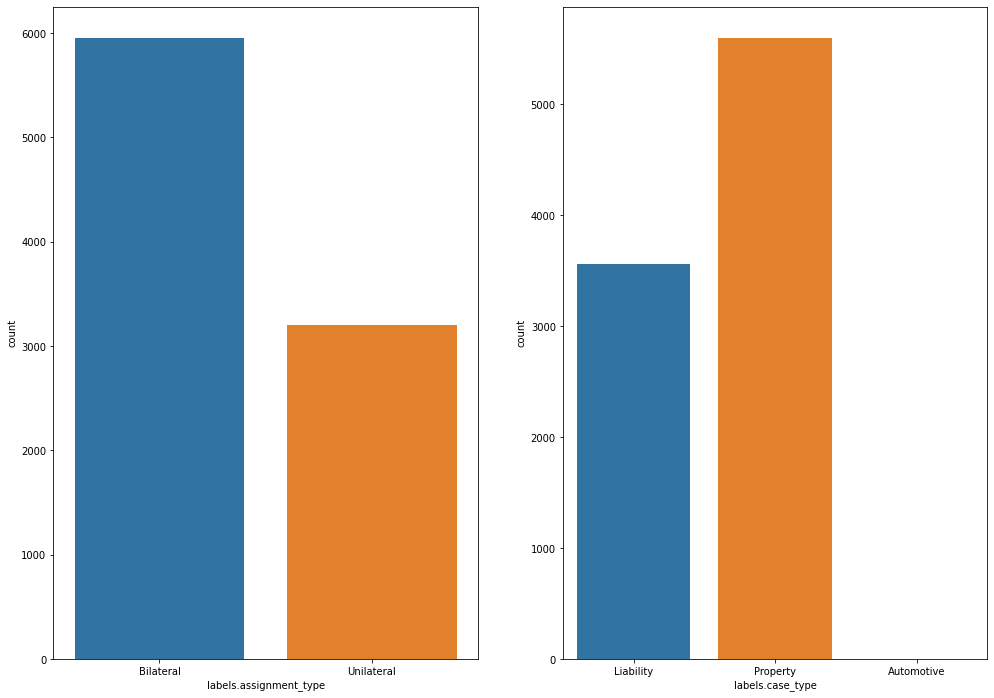

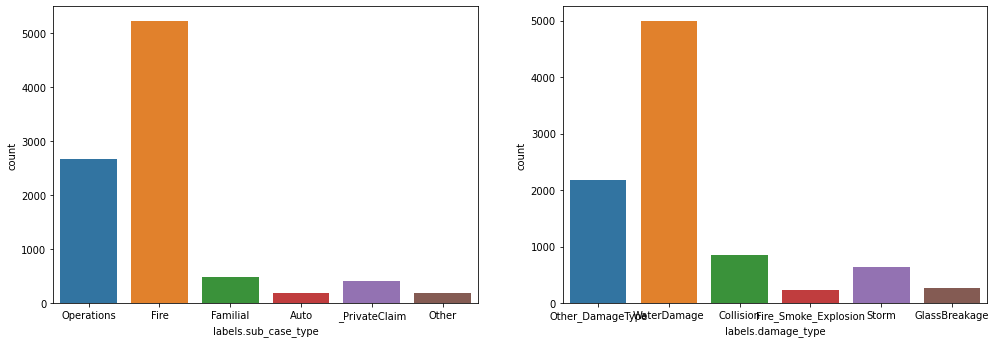

In [104]:
plt.figure(1 , figsize = (35 , 12))

plt.subplot(1 , 4 , 1)
sns.countplot(x="labels.assignment_type",data=dataset)
plt.subplot(1 , 4 , 2)
sns.countplot(x="labels.case_type",data=dataset)

plt.figure(2 , figsize = (35 , 12))
plt.subplot(2 , 4 , 1)
sns.countplot(x="labels.sub_case_type",data=dataset)
plt.subplot(2 , 4 , 2)
sns.countplot(x="labels.damage_type",data=dataset)

### Hier kunnen we al waarnemen dat onze dataset zeer ongebalanceerd is

In [105]:
#drop language en dergelijke 
dataset = dataset[['mail_content','attachments_filename','attachments_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type']]

In [106]:
y

,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
0,0,1,2,0
1,1,0,1,1
2,1,0,1,1
3,0,2,4,0
4,0,2,4,0
...,...,...,...,...
9156,0,1,4,0
9157,0,1,4,0
9158,0,1,4,0
9159,0,1,4,0


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7328, 3) (7328, 4)
(1833, 3) (1833, 4)


In [108]:
#Max number van woorden
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 150

In [109]:
#mail_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 542 unique tokens.
Shape of data X_train_mc: (7328, 400)
Shape of data X_train_mc: (1833, 400)


In [110]:
#attachments_filename Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

Found 14319 unique tokens.
Shape of data X_train_af: (7328, 200)
Shape of data X_test_af: (1833, 200)


In [111]:
#attachments_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 41564 unique tokens.
Shape of data X_train_ac: (7328, 500)
Shape of data X_train_ac: (1833, 500)


In [112]:
print(y)

      labels.case_type  labels.sub_case_type  labels.damage_type  \
0                    0                     1                   2   
1                    1                     0                   1   
2                    1                     0                   1   
3                    0                     2                   4   
4                    0                     2                   4   
...                ...                   ...                 ...   
9156                 0                     1                   4   
9157                 0                     1                   4   
9158                 0                     1                   4   
9159                 0                     1                   4   
9160                 0                     1                   2   

      labels.assignment_type  
0                          0  
1                          1  
2                          1  
3                          0  
4                          0

In [113]:
X_train_ac

array([[   0,    0,    0, ...,  174,  465,  161],
       [   0,    0,    0, ...,  174,  465,  161],
       [   0,    0,    0, ..., 1488,  175, 1455],
       ...,
       [  17,   38,   16, ..., 1192,  633,  636],
       [   0,    0,    0, ...,   16,  465,  161],
       [   0,    0,    0, ...,  387,  335, 3073]])

In [114]:
#train & test
y1_train=y_train[['labels.assignment_type']]
y1_test=y_test[['labels.assignment_type']]
y2_train=y_train[['labels.case_type']]
y2_test=y_test[['labels.case_type']]
y3_train=y_train[['labels.sub_case_type']]
y3_test=y_test[['labels.sub_case_type']]
y4_train=y_train[['labels.damage_type']]
y4_test=y_test[['labels.damage_type']]


print('Shape of label tensor Y1 Train:', y1_train.shape)
print('Shape of label tensor Y1 Test:', y1_test.shape)
print('Shape of label tensor Y2 Train:', y2_train.shape)
print('Shape of label tensor Y2 Test:', y2_test.shape)
print('Shape of label tensor Y3 Train:', y3_train.shape)
print('Shape of label tensor Y3 Test:', y3_test.shape)
print('Shape of label tensor Y4 Train:', y4_train.shape)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (7328, 1)
Shape of label tensor Y1 Test: (1833, 1)
Shape of label tensor Y2 Train: (7328, 1)
Shape of label tensor Y2 Test: (1833, 1)
Shape of label tensor Y3 Train: (7328, 1)
Shape of label tensor Y3 Test: (1833, 1)
Shape of label tensor Y4 Train: (7328, 1)
Shape of label tensor Y4 Test: (1833, 1)


## LSTM Modellen

### Voorspellen van labels.assignment_type

In [128]:
#unbalanced -> calculate balance weights
class_weights_assignment = dict(zip(np.unique(y1_train), class_weight.compute_class_weight('balanced',np.unique(y1_train),np.ravel(y1_train)))) 
print("class_weights:", class_weights_assignment)

# LSTM voor Y1_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 35)
# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))
model = Sequential()

embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.5)(embeding_mc)
o_mc=LSTM(32, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.5)(embeding_af)
o_af=LSTM(32, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.5)(embeding_ac)
o_ac=LSTM(32, dropout=0.4)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])

r=Dense(16, activation='relu')(concat_layer)

r1=Dense(8, activation='relu')(r)
r2=Dense(4, activation='relu')(r1)



lstm1 = Dense(2, activation='softmax')(r2)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([X_train_mc,X_train_af,X_train_ac], y1_train, validation_split=0.2,class_weight=class_weights_assignment, epochs=100,verbose=1,batch_size=64,callbacks=[es,mc])

c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


class_weights: {0: 0.7687788501888376, 1: 1.4301327088212334}
Epoch 1/100
92/92 [==============================] - 19s 207ms/step - loss: 0.6023 - accuracy: 0.7347 - val_loss: 0.4468 - val_accuracy: 0.8158
Epoch 2/100
92/92 [==============================] - 18s 191ms/step - loss: 0.4654 - accuracy: 0.8422 - val_loss: 0.3862 - val_accuracy: 0.8506
Epoch 3/100
92/92 [==============================] - 18s 194ms/step - loss: 0.3920 - accuracy: 0.8710 - val_loss: 0.3411 - val_accuracy: 0.8711
Epoch 4/100
92/92 [==============================] - 18s 196ms/step - loss: 0.3400 - accuracy: 0.8893 - val_loss: 0.3131 - val_accuracy: 0.8806
Epoch 5/100
92/92 [==============================] - 18s 194ms/step - loss: 0.3027 - accuracy: 0.9016 - val_loss: 0.2792 - val_accuracy: 0.8929
Epoch 6/100
92/92 [==============================] - 18s 194ms/step - loss: 0.2703 - accuracy: 0.9106 - val_loss: 0.2687 - val_accuracy: 0.8984
Epoch 7/100
92/92 [==============================] - 18s 196ms/step - loss

Epoch 57/100
92/92 [==============================] - 18s 195ms/step - loss: 0.0533 - accuracy: 0.9852 - val_loss: 0.2356 - val_accuracy: 0.9447
Epoch 58/100
92/92 [==============================] - 18s 195ms/step - loss: 0.0530 - accuracy: 0.9850 - val_loss: 0.2355 - val_accuracy: 0.9461
Epoch 59/100
92/92 [==============================] - 18s 193ms/step - loss: 0.0543 - accuracy: 0.9848 - val_loss: 0.2120 - val_accuracy: 0.9523
Epoch 60/100
92/92 [==============================] - 18s 195ms/step - loss: 0.0539 - accuracy: 0.9848 - val_loss: 0.2227 - val_accuracy: 0.9468
Epoch 61/100
92/92 [==============================] - 18s 194ms/step - loss: 0.0528 - accuracy: 0.9852 - val_loss: 0.2484 - val_accuracy: 0.9454
Epoch 62/100
92/92 [==============================] - 18s 191ms/step - loss: 0.0538 - accuracy: 0.9857 - val_loss: 0.2186 - val_accuracy: 0.9393
Epoch 63/100
92/92 [==============================] - 17s 189ms/step - loss: 0.0526 - accuracy: 0.9853 - val_loss: 0.2064 - val_ac

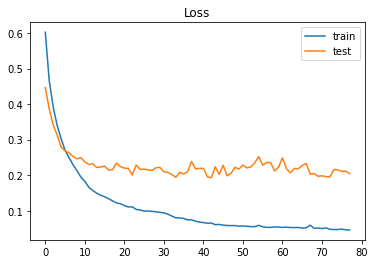

In [129]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

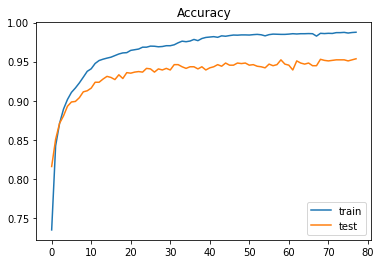

In [130]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Voorspellen van labels.case_type

In [122]:
# LSTM voor Y2_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 35)
# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()

embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(64, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(64, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(64, dropout=0.4)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])


r=Dense(32, activation='relu')(concat_layer)
r1=Dense(16, activation='relu')(r)
r2=Dense(8, activation ='relu')(r1)
r3=Dense(4, activation='relu')(r2)

lstm1 = Dense(3, activation='softmax')(r3)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit([X_train_mc,X_train_af,X_train_ac], y2_train, validation_split=0.2, epochs=100,verbose=1,batch_size=64,callbacks=[es], class_weight={0: 0.8066606840163526, 1: 0.5681977805871611, 2: 2.6666666666665})

Epoch 1/100
92/92 [==============================] - 20s 220ms/step - loss: 0.6325 - accuracy: 0.6047 - val_loss: 0.6786 - val_accuracy: 0.6023
Epoch 2/100
92/92 [==============================] - 18s 194ms/step - loss: 0.4246 - accuracy: 0.7021 - val_loss: 0.5392 - val_accuracy: 0.7749
Epoch 3/100
92/92 [==============================] - 18s 191ms/step - loss: 0.3213 - accuracy: 0.7886 - val_loss: 0.4271 - val_accuracy: 0.8117
Epoch 4/100
92/92 [==============================] - 18s 191ms/step - loss: 0.2671 - accuracy: 0.8419 - val_loss: 0.3776 - val_accuracy: 0.8383
Epoch 5/100
92/92 [==============================] - 18s 191ms/step - loss: 0.2125 - accuracy: 0.8821 - val_loss: 0.2964 - val_accuracy: 0.8997
Epoch 6/100
92/92 [==============================] - 18s 196ms/step - loss: 0.1534 - accuracy: 0.9197 - val_loss: 0.2049 - val_accuracy: 0.9413
Epoch 7/100
92/92 [==============================] - 18s 197ms/step - loss: 0.1045 - accuracy: 0.9509 - val_loss: 0.1778 - val_accuracy:

92/92 [==============================] - 21s 224ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0688 - val_accuracy: 0.9850
Epoch 58/100
92/92 [==============================] - 21s 230ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0758 - val_accuracy: 0.9829
Epoch 59/100
92/92 [==============================] - 19s 212ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0753 - val_accuracy: 0.9857
Epoch 60/100
92/92 [==============================] - 19s 208ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.1088 - val_accuracy: 0.9782
Epoch 61/100
92/92 [==============================] - 19s 210ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1066 - val_accuracy: 0.9775
Epoch 62/100
92/92 [==============================] - 19s 210ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0963 - val_accuracy: 0.9802
Epoch 00062: early stopping


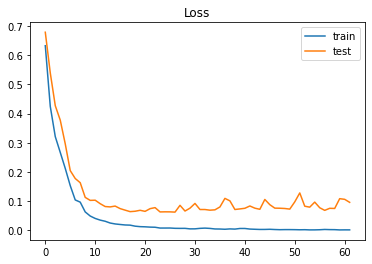

In [123]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

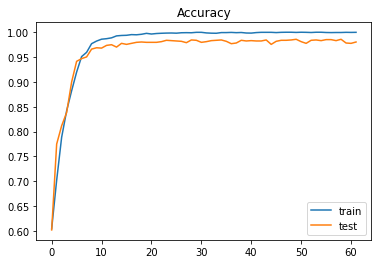

In [124]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Voorspellen van labels.sub_case_type

In [125]:
# LSTM voor Y3_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 35)
# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(32, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(32, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(32, dropout=0.4)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])

r=Dense(16, activation='relu')(concat_layer)
r1=Dense(8, activation='relu')(r)

lstm1 = Dense(6, activation='softmax')(r1)
model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit([X_train_mc,X_train_af,X_train_ac], y3_train, validation_split=0.2, epochs=100,verbose=1,batch_size=64,callbacks=[es], class_weight={0: 0.28982755893054896,1: 0.5715177039463423,2: 1.188859878154917,3: 1.9525350593311757,4: 2.196868008948545,5: 2.980392156862745})

Epoch 1/100
92/92 [==============================] - 21s 225ms/step - loss: 1.0182 - accuracy: 0.4297 - val_loss: 1.7081 - val_accuracy: 0.6910
Epoch 2/100
92/92 [==============================] - 18s 198ms/step - loss: 0.9603 - accuracy: 0.6921 - val_loss: 1.3560 - val_accuracy: 0.7292
Epoch 3/100
92/92 [==============================] - 18s 196ms/step - loss: 0.8882 - accuracy: 0.7074 - val_loss: 1.1743 - val_accuracy: 0.7012
Epoch 4/100
92/92 [==============================] - 18s 197ms/step - loss: 0.8342 - accuracy: 0.7405 - val_loss: 1.0847 - val_accuracy: 0.7517
Epoch 5/100
92/92 [==============================] - 18s 194ms/step - loss: 0.7719 - accuracy: 0.8013 - val_loss: 0.9228 - val_accuracy: 0.8124
Epoch 6/100
92/92 [==============================] - 18s 196ms/step - loss: 0.7000 - accuracy: 0.8327 - val_loss: 0.8320 - val_accuracy: 0.8302
Epoch 7/100
92/92 [==============================] - 19s 202ms/step - loss: 0.6367 - accuracy: 0.8454 - val_loss: 0.7004 - val_accuracy:

92/92 [==============================] - 18s 199ms/step - loss: 0.0279 - accuracy: 0.9916 - val_loss: 0.3041 - val_accuracy: 0.9222
Epoch 58/100
92/92 [==============================] - 18s 198ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.3270 - val_accuracy: 0.9188
Epoch 59/100
92/92 [==============================] - 18s 194ms/step - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.3258 - val_accuracy: 0.9195
Epoch 60/100
92/92 [==============================] - 18s 194ms/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.3151 - val_accuracy: 0.9243
Epoch 61/100
92/92 [==============================] - 18s 196ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.3182 - val_accuracy: 0.9236
Epoch 62/100
92/92 [==============================] - 18s 194ms/step - loss: 0.0218 - accuracy: 0.9925 - val_loss: 0.3186 - val_accuracy: 0.9222
Epoch 63/100
92/92 [==============================] - 18s 194ms/step - loss: 0.0223 - accuracy: 0.9923 - val_loss: 0.3200 - val_accuracy: 0.920

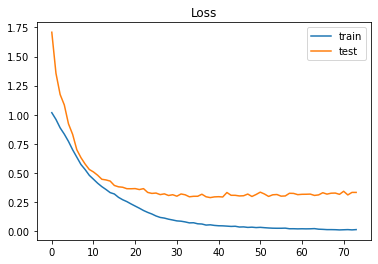

In [126]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

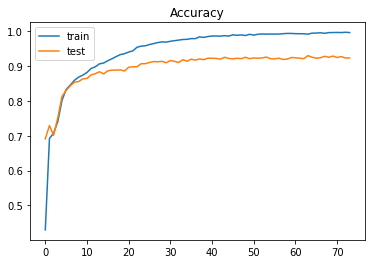

In [127]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Voorspellen van labels.damage_type

In [54]:
class_weights_damage_type = dict(zip(np.unique(y4_train), class_weight.compute_class_weight('balanced', np.unique(y4_train), np.ravel(y4_train)))) 
print("class_xweights", class_weights_damage_type)
# LSTM voor Y4_TRAIN
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 35)

# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(256, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(256, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(256, dropout=0.4)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])
r=Dense(128, activation='relu')(concat_layer)
r1=Dense(64, activation='relu')(r)
r2=Dense(32, activation='relu')(r1)
r3=Dense(16, activation='relu')(r2)
lstm1 = Dense(6, activation='softmax')(r3)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac], y4_train, validation_split=0.2, epochs=200,verbose=1,batch_size=64,callbacks=[es,mc],class_weight=class_weights_damage_type)

Epoch 1/200
92/92 [==============================] - 27s 295ms/step - loss: 1.7785 - accuracy: 0.2834 - val_loss: 1.6930 - val_accuracy: 0.2538
Epoch 2/200
92/92 [==============================] - 25s 268ms/step - loss: 1.6180 - accuracy: 0.2721 - val_loss: 1.6293 - val_accuracy: 0.2333
Epoch 3/200
92/92 [==============================] - 25s 266ms/step - loss: 1.3326 - accuracy: 0.3002 - val_loss: 1.4130 - val_accuracy: 0.2988
Epoch 4/200
92/92 [==============================] - 26s 280ms/step - loss: 1.0241 - accuracy: 0.4933 - val_loss: 0.9898 - val_accuracy: 0.6126
Epoch 5/200
92/92 [==============================] - 25s 276ms/step - loss: 0.6129 - accuracy: 0.7325 - val_loss: 0.7755 - val_accuracy: 0.7374
Epoch 6/200
92/92 [==============================] - 26s 279ms/step - loss: 0.3696 - accuracy: 0.8541 - val_loss: 0.5926 - val_accuracy: 0.8131
Epoch 7/200
92/92 [==============================] - 26s 286ms/step - loss: 0.2995 - accuracy: 0.8830 - val_loss: 0.5313 - val_accuracy:

92/92 [==============================] - 26s 278ms/step - loss: 0.0182 - accuracy: 0.9916 - val_loss: 0.4986 - val_accuracy: 0.8984
Epoch 58/200
92/92 [==============================] - 25s 276ms/step - loss: 0.0224 - accuracy: 0.9901 - val_loss: 0.6186 - val_accuracy: 0.8793
Epoch 59/200
92/92 [==============================] - 25s 275ms/step - loss: 0.0597 - accuracy: 0.9809 - val_loss: 0.4612 - val_accuracy: 0.8963
Epoch 60/200
92/92 [==============================] - 26s 278ms/step - loss: 0.0317 - accuracy: 0.9889 - val_loss: 0.4921 - val_accuracy: 0.8847
Epoch 61/200
92/92 [==============================] - 26s 288ms/step - loss: 0.0247 - accuracy: 0.9911 - val_loss: 0.5271 - val_accuracy: 0.8854
Epoch 62/200
92/92 [==============================] - 27s 290ms/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 0.4825 - val_accuracy: 0.8936
Epoch 63/200
92/92 [==============================] - 26s 281ms/step - loss: 0.0327 - accuracy: 0.9916 - val_loss: 0.5657 - val_accuracy: 0.882

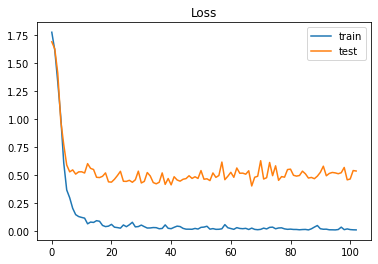

In [57]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

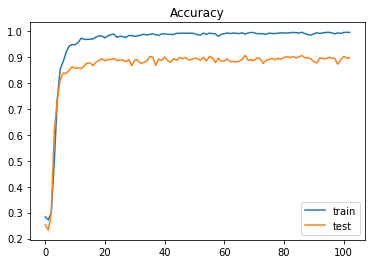

In [58]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();